In [96]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, root_mean_squared_log_error
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam

movies = pd.read_csv('movies_data.csv')

### Feature Engineering :D

In [97]:
def convert_to_list(x):
    if isinstance(x, str) and x.strip():  # Check if x is a non-empty string
        return [item.strip() for item in x.split(',')]
    return ['not listed'] 

# Apply the conversion function to movies and production companies
movies['genres'] = movies['genres'].apply(convert_to_list)
movies['production_companies'] = movies['production_companies'].apply(convert_to_list)
movies.head()

,id,title,release_date,revenue,budget,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,sentiment
0,5,Four Rooms,1995-12-09,4257354,4000000,"[Miramax, A Band Apart]",[Comedy],13.275,5.800,2618,It's Ted the Bellhop's first night on the job....,No reviews available,0.0000
1,6,Judgment Night,1993-10-15,12136938,21000000,"[Largo Entertainment, JVC, Universal Pictures]","[Action, Crime, Thriller]",9.284,6.500,331,"Four young friends, while taking a shortcut en...",No reviews available,0.0000
2,11,Star Wars,1977-05-25,775398007,11000000,"[Lucasfilm Ltd., 20th Century Fox]","[Adventure, Action, Science Fiction]",81.543,8.200,20457,Princess Leia is captured and held hostage by ...,"(As I'm writing this review, Darth Vader's the...",0.9998
3,12,Finding Nemo,2003-05-30,940335536,94000000,[Pixar],"[Animation, Family]",85.328,7.819,19102,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,0.9976
4,13,Forrest Gump,1994-06-23,677387716,55000000,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",106.538,8.472,27251,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,0.9963


### Getting release year/month/week

In [98]:
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Extract year, month, and week number as new columns
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month
movies['release_week'] = movies['release_date'].dt.isocalendar().week  # Week number of the year

movies.head()

,id,title,release_date,revenue,budget,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,sentiment,release_year,release_month,release_week
0,5,Four Rooms,1995-12-09,4257354,4000000,"[Miramax, A Band Apart]",[Comedy],13.275,5.800,2618,It's Ted the Bellhop's first night on the job....,No reviews available,0.0000,1995,12,49
1,6,Judgment Night,1993-10-15,12136938,21000000,"[Largo Entertainment, JVC, Universal Pictures]","[Action, Crime, Thriller]",9.284,6.500,331,"Four young friends, while taking a shortcut en...",No reviews available,0.0000,1993,10,41
2,11,Star Wars,1977-05-25,775398007,11000000,"[Lucasfilm Ltd., 20th Century Fox]","[Adventure, Action, Science Fiction]",81.543,8.200,20457,Princess Leia is captured and held hostage by ...,"(As I'm writing this review, Darth Vader's the...",0.9998,1977,5,21
3,12,Finding Nemo,2003-05-30,940335536,94000000,[Pixar],"[Animation, Family]",85.328,7.819,19102,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,0.9976,2003,5,22
4,13,Forrest Gump,1994-06-23,677387716,55000000,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",106.538,8.472,27251,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,0.9963,1994,6,25


#### Time Series plot of total revenue per Month

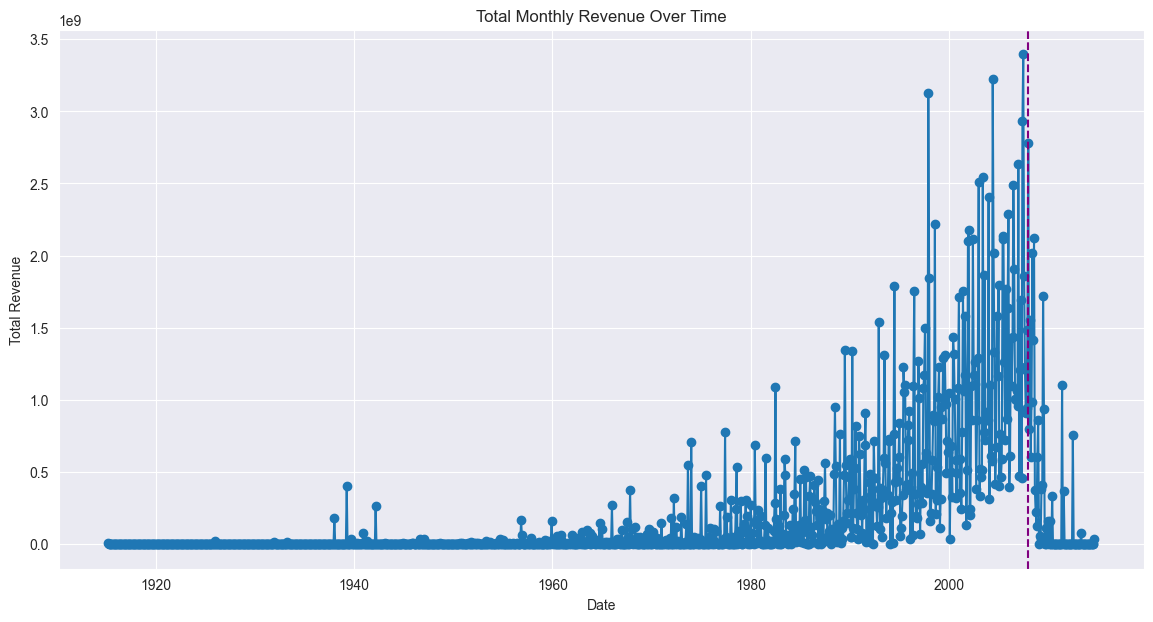

In [99]:
# Set 'release_date' as the index for time series plotting
movies1 = movies.set_index('release_date')

# Resample revenue data by month 
monthly_revenue = movies1['revenue'].resample('ME').sum()  # Sum revenue per month

# Step 4: Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.axvline(pd.to_datetime('2008-01-01'), color='purple', linestyle='--', label='2008 Market Crash')
plt.title('Total Monthly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

#### Line plot of average weekly revenue

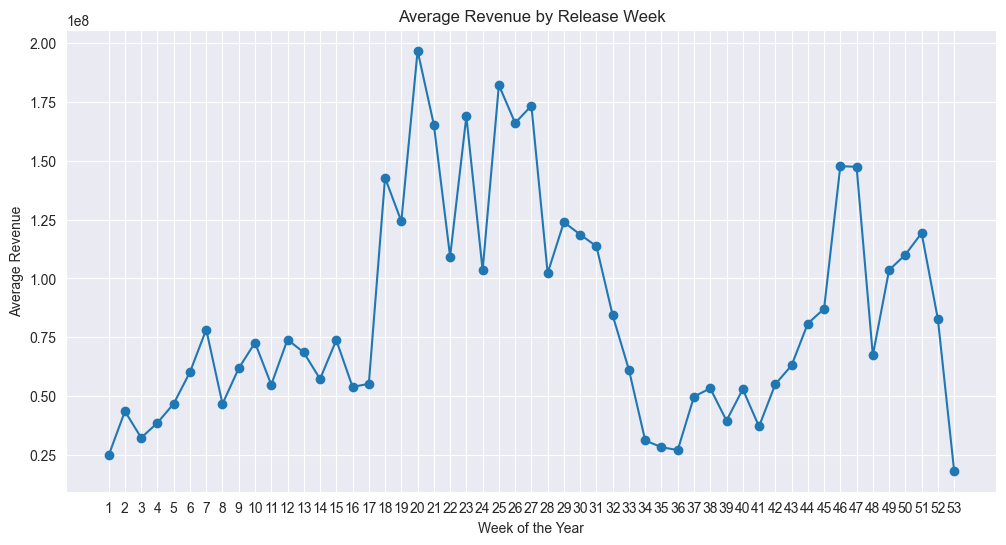

In [100]:
# Calculate average revenue for each week
weekly_revenue = movies.groupby('release_week')['revenue'].mean().reset_index()

# Step 3: Plot the correlation
plt.figure(figsize=(12, 6))
plt.plot(weekly_revenue['release_week'], weekly_revenue['revenue'], marker='o')
plt.title('Average Revenue by Release Week')
plt.xlabel('Week of the Year')
plt.ylabel('Average Revenue')
plt.xticks(range(1, 54))  # Weeks go from 1 to 53 in some years
plt.grid(True)
plt.show()

#### Creating Holiday variables

In [101]:
movies['thanksgiving_release'] = movies['release_week'].isin([46, 47]).astype(int)
movies['christmas_release'] = movies['release_week'].isin([50, 51]).astype(int)

print(f"Christmas movies: {movies['christmas_release'].sum()} \nThanksgiving Movies: {movies['thanksgiving_release'].sum()}")

Christmas movies: 210 
Thanksgiving Movies: 113


### Creating Production level: Based on average revenue and number of movies produced

In [102]:
# Step 1: Explode the 'production_companies' column and calculate average revenue and movie count
movies_exploded = movies.explode('production_companies')
company_stats = movies_exploded.groupby('production_companies').agg(
    avg_revenue=('revenue', 'mean'),
    movie_count=('production_companies', 'count')
).reset_index()

# Step 2: Apply log transformation to the revenue and movie count
company_stats['log_avg_revenue'] = np.log1p(company_stats['avg_revenue'])  # log(1 + revenue) to avoid log(0)
company_stats['log_movie_count'] = np.log1p(company_stats['movie_count'])  # log(1 + count) to handle 0s

# Step 3: Standardize the log-transformed features to balance their scale
scaler = StandardScaler()
company_stats[['log_avg_revenue', 'log_movie_count']] = scaler.fit_transform(company_stats[['log_avg_revenue', 'log_movie_count']])

# Step 4: Calculate the combined score based on standardized log-transformed revenue and movie count
alpha = 0.5  # Revenue weight
beta = 0.5  # Movie count weight
company_stats['score'] = alpha * company_stats['log_avg_revenue'] + beta * company_stats['log_movie_count']

# Step 5: Rank companies based on score and assign levels
top_threshold = company_stats['score'].quantile(0.95)  # Top 5% as top companies
mid_threshold = company_stats['score'].quantile(0.6)  # Middle 35% as mid-level companies

def classify_company(score):
    if score >= top_threshold:
        return 'Top-level'
    elif score >= mid_threshold:
        return 'Mid-level'
    else:
        return 'Low-level'

company_stats['production_level'] = company_stats['score'].apply(classify_company)

# Create a dictionary to map each company to its production level
production_level_map = company_stats.set_index('production_companies')['production_level'].to_dict()

# Step 6: Implement weighted average approach for categorizing movies based on their production companies
def weighted_average_level(companies):
    levels = [production_level_map.get(company, 'Low-level') for company in companies]
    
    # Assign numerical values for each level (Top-level: 3, Mid-level: 2, Low-level: 1)
    level_values = {'Top-level': 3, 'Mid-level': 2, 'Low-level': 1}
    numeric_levels = [level_values[level] for level in levels]

    # Compute the weighted average of levels for all companies
    avg_level = sum(numeric_levels) / len(numeric_levels) if numeric_levels else 1  # Default to 'Low-level' if no valid companies

    # Classify based on average level
    if avg_level >= 2.8:
        return 'Top'
    elif avg_level >= 2.0:
        return 'Mid'
    else:
        return 'Low'

# Step 7: Apply the weighted average approach to each movie
movies['production_level'] = movies['production_companies'].apply(weighted_average_level)

# View the top 20 companies and their production levels
movies.head()

,id,title,release_date,revenue,budget,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,sentiment,release_year,release_month,release_week,thanksgiving_release,christmas_release,production_level
0,5,Four Rooms,1995-12-09,4257354,4000000,"[Miramax, A Band Apart]",[Comedy],13.275,5.800,2618,It's Ted the Bellhop's first night on the job....,No reviews available,0.0000,1995,12,49,0,0,Mid
1,6,Judgment Night,1993-10-15,12136938,21000000,"[Largo Entertainment, JVC, Universal Pictures]","[Action, Crime, Thriller]",9.284,6.500,331,"Four young friends, while taking a shortcut en...",No reviews available,0.0000,1993,10,41,0,0,Mid
2,11,Star Wars,1977-05-25,775398007,11000000,"[Lucasfilm Ltd., 20th Century Fox]","[Adventure, Action, Science Fiction]",81.543,8.200,20457,Princess Leia is captured and held hostage by ...,"(As I'm writing this review, Darth Vader's the...",0.9998,1977,5,21,0,0,Top
3,12,Finding Nemo,2003-05-30,940335536,94000000,[Pixar],"[Animation, Family]",85.328,7.819,19102,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,0.9976,2003,5,22,0,0,Top
4,13,Forrest Gump,1994-06-23,677387716,55000000,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",106.538,8.472,27251,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,0.9963,1994,6,25,0,0,Mid


In [103]:
production_summary = movies.groupby('production_level').agg(
    total_revenue=('revenue', 'mean'),
    movie_count=('revenue', 'count')
).reset_index()

# Step 2: Display the summary
print(production_summary)

  production_level  total_revenue  movie_count
0              Low   1.265212e+07          651
1              Mid   9.608925e+07         1394
2              Top   1.651170e+08          575


In [104]:
movies['log_revenue'] = np.log1p(movies['revenue'])
movies['log_budget'] = np.log1p(movies['budget'])

### Fitting a Random Forest Pipeline

In [105]:
# Step 1: Fit the MultiLabelBinarizer on the genres data (on the entire dataset)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Create a DataFrame from the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=movies.index)

# Concatenate the genre DataFrame with the original dataset
movies = pd.concat([movies, genres_df], axis=1)

In [106]:
movie_titles = movies['title']
X = movies.drop(columns=['log_revenue', 'revenue', 'budget', 'title', 'id', 'overview', 'reviews', 'genres', 'release_date'])  # Features
y = movies['log_revenue']  # Target

# Define the categorical and numerical columns
categorical_cols = ['production_level']  # Only 'production_level' as a categorical variable
numerical_cols = ['log_budget', 'popularity', 'vote_average', 'vote_count', 'sentiment','release_year', 'release_month', 'release_week', 'thanksgiving_release', 'christmas_release'] + list(mlb.classes_)

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numeric features
        ('cat', OneHotEncoder(), categorical_cols),  # One-hot encode categorical features
    ])

# Define the model pipeline
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)

# Calculate Mean Squared Error
rmse_rf = root_mean_squared_log_error(y_test, y_pred_rf)  

print(f'Root Mean Squared Log Error (Random Forest): {rmse_rf}')

Root Mean Squared Log Error (Random Forest): 0.09911223901376334


### Fitting an SVM 

In [107]:
model_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C =10, epsilon = 1))
])

model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

rmse_svm = root_mean_squared_log_error(y_test, y_pred_svm)

print(f'Root Mean Squared Log Error (SVM): {rmse_svm}')

Root Mean Squared Log Error (SVM): 0.10809974471457932


In [108]:
# Inverse transform the predicted values and actual values from log scale to original scale
y_pred_rf_original = np.exp(y_pred_rf)
y_pred_svm_original = np.exp(y_pred_svm)
y_actual = np.exp(y_test)

pred_df = pd.DataFrame({
    "Actual Revenue": y_actual, 
    "RF Predicted Revenue": y_pred_rf_original,
    "SVM Predicted Revenue": y_pred_svm_original
})
pred_df.head(20)

,Actual Revenue,RF Predicted Revenue,SVM Predicted Revenue
2241,30700001.0,3.116838e+07,2.248337e+07
175,95708458.0,1.373710e+08,1.469290e+08
1253,4812445.0,3.066180e+06,3.606535e+06
1461,9129248.0,3.267418e+06,1.078459e+07
2443,9056074.0,6.912356e+06,9.491678e+06
1288,48443735.0,6.577003e+07,3.777556e+07
581,885534.0,3.375058e+05,1.433019e+05
2296,250800001.0,1.823669e+08,1.639190e+08
2462,21722777.0,1.896252e+07,6.267233e+07
1071,8493891.0,2.347039e+07,3.769418e+07


### Fitting an RNN

In [109]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Reshape data for RNN (RNN expects [samples, timesteps, features])
X_train_processed = X_train_processed.reshape((X_train_processed.shape[0], 1, X_train_processed.shape[1]))
X_test_processed = X_test_processed.reshape((X_test_processed.shape[0], 1, X_test_processed.shape[1]))

# Define the RNN model
model_rnn = Sequential()

# Add a SimpleRNN layer (you can experiment with units)
model_rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_processed.shape[1], X_train_processed.shape[2])))

# Add a Dropout layer to prevent overfitting
model_rnn.add(Dropout(0.5))

# Add a Dense layer for the output (1 output value for regression)
model_rnn.add(Dense(1))

# Compile the model with Mean Squared Logarithmic Error as loss function for regression
model_rnn.compile(optimizer=Adam(), loss='mean_squared_logarithmic_error')

# Train the RNN model
model_rnn.fit(X_train_processed, y_train, epochs=50, batch_size=32, validation_data=(X_test_processed, y_test))

# Predict on the test set
y_pred_rnn = model_rnn.predict(X_test_processed)

# Calculate Root Mean Squared Log Error (RMSLE)
rmse_rnn = root_mean_squared_log_error(y_test, y_pred_rnn)

print(f'Root Mean Squared Log Error (RNN): {rmse_rnn}')

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 5.8283 - val_loss: 3.1382
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8896 - val_loss: 1.6987
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6751 - val_loss: 1.0771
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1676 - val_loss: 0.7145
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7939 - val_loss: 0.4849
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5529 - val_loss: 0.3334
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4091 - val_loss: 0.2311
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3315 - val_loss: 0.1613
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2335 - val_loss: 0.1140
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1938 - val_loss: 0.0813
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1612 - val_loss: 0.0593
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1372 - val_l